In [1]:
print("Settings.py should be e.g. vgg_224")
#DESIGN PARAMETERS FOR NEURAL NETWORK
NR_LSTM_UNITS = 2 
IMAGE_INPUT_SIZE_W = 640
IMAGE_INPUT_SIZE_H = 480

IMAGE_AFTER_CONV_SIZE_W = 10
IMAGE_AFTER_CONV_SIZE_H = 7
#for 3x3 kernels, n=num_layers: len_in = 2^n*len_out + sum[i=1..n](2^i)
#CONV_LAYER_LENGTH = 5

VGG_FEATURE_CHANNELS_OUT = 512
LSTM_IO_SIZE = IMAGE_AFTER_CONV_SIZE_W * IMAGE_AFTER_CONV_SIZE_H * VGG_FEATURE_CHANNELS_OUT
LSTM_HIDDEN_SIZE = 1000


RGB_CHANNELS = 3
TIMESTEPS = 15 # size videos
BATCH_SIZE = 2 #until now just batch_size = 1
SLICE_FROM_TIMESTEP = 10 #slices from timestep SLICE_FROM_TIMESTEP to the last one

NR_EPOCHS = 20

VALIDATION_SPLIT = 0.0 #indicated ratio of training to validation data: 0.2 -> 20% VALIDATION data
RANDOMIZED_SEED = 20
SHUFFLE_DATASET = False

learning_rate = 0.0003 # reduce factos of 10 .. some epoch later.
momentum = 0.9
print("Hyperparameters defined")

Settings.py should be e.g. vgg_224
Hyperparameters defined


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import os.path as path
import copy
import matplotlib.pyplot as plt
# from torch.utils.data.sampler import SequentialSampler


from gait_analysis import AnnotationsCasia as Annotations
from gait_analysis import CasiaDataset
from gait_analysis.Config import Config
from gait_analysis import Composer

import matplotlib.pyplot as plt

print("done")

done


In [3]:
#change configuration in settings.py
crop_im_size = [186,250]
c = Config()
c.config['indexing']['grouping'] = 'person_sequence_angle'
c.config['transformers']['DimensionResize']['dimension'] = TIMESTEPS
#c.config['indexing']['people selection'] = [1]
#c.config['indexing']['sequences_selection'] = ['nm-01']
# c.config['pose']['load'] = False
# c.config['flow']['load'] = True
# c.config['heatmaps']['load'] = False
#c.config['scenes']['sequences'] = ['nm']
#c.config['scenes']['angles'] = ['108']
# c.config['dataset_output'] = {
# #         'data': ["scenes","flows","heatmaps_LAnkle","heatmaps_RAnkle"],
#         'data': ['flows'],
#         'label': "annotations"}
composer = Composer()
transformer = composer.compose()
dataset = CasiaDataset(transform=transformer)
print("Desired configuration: VGG_224")

loading configuration  vgg_224
[OK]
Desired configuration: VGG_224


In [4]:
a,b = dataset[1]
type(a["scenes"][0])
print(a["scenes"][0].size())



torch.Size([3, 320, 240])


tensor(16, dtype=torch.int32)
tensor(200, dtype=torch.int32)
tensor(18, dtype=torch.int32)
tensor(202, dtype=torch.int32)
tensor(18, dtype=torch.int32)
tensor(201, dtype=torch.int32)


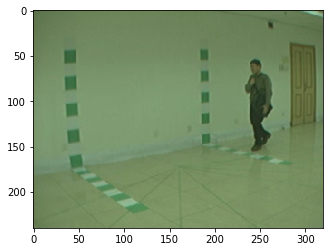

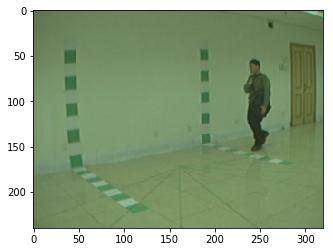

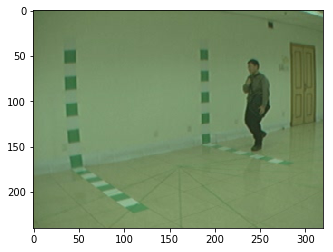

In [5]:
fig1 = plt.figure(1)
test_image = a["scenes"][0].int()
print(test_image.min())
print(test_image.max())
test_image = test_image.permute(2,1,0)
plt.imshow(test_image)

fig2 = plt.figure(2)
test_image = a["scenes"][1].int()
print(test_image.min())
print(test_image.max())
test_image = test_image.permute(2,1,0)
plt.imshow(test_image)

fig3 = plt.figure(3)
test_image = a["scenes"][2].int()
print(test_image.min())
print(test_image.max())
test_image = test_image.permute(2,1,0)
plt.imshow(test_image)

# Settings 
## Dataset

In [6]:
dataset_size = len(dataset)
indices = list(range(dataset_size))
print("Dataset size:", len(dataset))
print("Indices size:", len(indices))
split = int(np.floor(VALIDATION_SPLIT * dataset_size))
print("Split:", split)
if SHUFFLE_DATASET:
    np.random.seed(RANDOMIZED_SEED)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]
train_sampler = torch.utils.data.SequentialSampler(train_indices)
test_sampler = torch.utils.data.SequentialSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

# #

Dataset size: 140
Indices size: 140
Split: 0


## neural network

In [7]:
original_vgg = torchvision.models.vgg16(pretrained=True)
for param in original_vgg.parameters():
            original_vgg.requires_grad = False

class TEST_CNN_LSTM(nn.Module):
    def __init__(self):
        super(TEST_CNN_LSTM, self).__init__()
        self.avialable_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        print("Setting up VGG Features")
        self.vgg = nn.Sequential(original_vgg.features.eval())
#         print("Eliminating gradient")
#         for param in self.vgg.features.paramters():
#             original_vgg.require_grad = False
        print("Setting up VGG Features without gradient done")
        self.lstm1 = nn.LSTM(LSTM_IO_SIZE,
                            LSTM_HIDDEN_SIZE)# horizontal direction
#         self.lstm2 = nn.LSTM(LSTM_IO_SIZE,
#                             LSTM_HIDDEN_SIZE,
#                             TIMESTEPS)# horizontal direction
        self.fc1 = nn.Linear(LSTM_HIDDEN_SIZE,512)
        self.fc2 = nn.Linear(512,120)
        self.fc3 = nn.Linear(120,3)
        
        #initialize hidden states of LSTM
        self.hidden = self.init_hidden()

        #print("Hidden:", _hidden)
    def init_hidden(self):
        return (torch.randn(TIMESTEPS, BATCH_SIZE, LSTM_HIDDEN_SIZE).to(self.avialable_device), 
                torch.randn(TIMESTEPS, BATCH_SIZE, LSTM_HIDDEN_SIZE).to(self.avialable_device))
    def forward(self,x):
#         print("Input list len:",len(x))
#         print("Input elemens size:", x[0].size())
#         batch_size = x[0].size()[0]
        x_arr = torch.zeros(TIMESTEPS,BATCH_SIZE,VGG_FEATURE_CHANNELS_OUT,IMAGE_AFTER_CONV_SIZE_W,IMAGE_AFTER_CONV_SIZE_H).to(self.avialable_device)
        #print("X arr size", x_arr.size())
        #print("X size", len(x))
        for i in range(TIMESTEPS):#parallel convolutions which are later concatenated for LSTM
            x_tmp_c1 = self.vgg(x[i])
            x_arr[i,:,:,:,:] = x_tmp_c1
#             print("Done",i)
        
        #print(x_arr.size())
        #lakadjdksjd
        #x = torch.cat((x_arr[0],
        #      x_arr[1],
        #      x_arr[2],
        #      x_arr[3],
        #      x_arr[4],
        #      x_arr[5],
        #      x_arr[6],
        #      x_arr[7],
        #      x_arr[8],
        #      x_arr[9]),0)
        
        #x, hidden = self.lstm1(x_arr.view(TIMESTEPS,BATCH_SIZE,-1), self.hidden)
        x, hidden = self.lstm1(x_arr.view(TIMESTEPS,BATCH_SIZE,-1))
        #print('----------------------------------')
        #print(x.size())
#         x, hidden = self.lstm2(x, self.hidden)
        # the reshaping was taken from the documentation... and makes sense
        x = x.view(TIMESTEPS,BATCH_SIZE,LSTM_HIDDEN_SIZE) #output.view(seq_len, batch, num_dir*hidden_size)
#         x = torch.squeeze(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        #print(x.size())
        #x = x.squeeze(1)
        x = x.permute(1,2,0)
        #print(x.size())
        #print ("Size network output", x.shape)
        return x
print("Class defined")

Class defined


In [8]:
### define and execute testing function
def test_all_preds(model):
    n_batches_test = len(test_loader)

    #Time for printing
    testing_start_time = time.time()

    print('Start testing...')
    correct = 0 
    total = 0
    with torch.no_grad():
        for i, batch in enumerate(train_loader):
            inputs, labels = batch
            
            data_in = [s.to(device) for s in inputs['flows']]
            labels = labels.to(device)
            if not labels.size()[0] == BATCH_SIZE:
                # skip uncompleted batch size NN is fixed to BATCHSIZE
                continue
            outputs = model(data_in)
#             print("Out:", len(outputs), outputs.size())
#             print("Labels:", len(labels), labels.size())
            _, predicted = torch.max(outputs.data, 1)
#             print('predicted:',len(predicted),predicted.size())
            n_errors = torch.nonzero(torch.abs(labels.long() - predicted)).size(0)
            total += predicted.numel()
            # print('predicted',predicted)
            correct += predicted.numel() - n_errors
            # print('labels',labels)
    print('Accuracy {:.2f}%'.format(100*correct/total))
    print('...testing finished')
print("Definition done")

Definition done


### Test-Training

In [9]:
#TRAINING
test_net = TEST_CNN_LSTM()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
test_net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(test_net.parameters(), lr=learning_rate, momentum=momentum)


Setting up VGG Features
Setting up VGG Features without gradient done
cuda:0


In [10]:
# parameters_conv5_init = list(test_net.conv5.parameters())
# bias_conv5_init = np.sort(parameters_conv5_init[1].detach().numpy())
# weights_conv5_init = np.sort(parameters_conv5_init[0].detach().numpy().flatten())

# parameters_fc1_init = list(test_net.fc1.parameters())
# bias_fc1_init = np.sort(parameters_fc1_init[1].detach().numpy())
# weights_fc1_init = np.sort(parameters_fc1_init[0].detach().numpy().flatten())

# a = list(test_net.lstm2.parameters())
# weights_lstm2_init = np.array([])
# for item in a:
#     item = item.detach().numpy().flatten()
#     #print(item)
#     weights_lstm2_init = np.concatenate((weights_lstm2_init,item))
# print("Saved initial parameters")

In [11]:
# a = list(test_net.lstm1.parameters())
# b = [item for sublist in a for item in sublist]
# l = np.array([])
# #print(a[0])
# for item in a:
#     item = item.detach().numpy().flatten()
#     #print(item)
#     l = np.concatenate((l,item))
# print(l)
# #plt.plot(l)

### Test set and evaluate computing time etc.

In [12]:
#PREPARATION FOR TRAINING
loss_array = []
learning_rate_array = []

print('Start training...')
print("Expected loss with {} different classes and {} data elements: {}".format(3, len(dataset)-split, (len(dataset)-split)*np.log(3)))
running_loss = 0.0
#print("Data set length:", len((train_loader)), "Validation length:", len(test_loader))
print("Batch size:", BATCH_SIZE)
print("Evaluating first element...")
start_time = time.time()
i, batch = next(iter(enumerate(train_loader)))
inputs, labels = batch
data_in = [s.to(device) for s in inputs['scenes']]
labels = labels.to(device)
print("Time steps:{}, input sequence length:{}".format(TIMESTEPS,len(data_in)))
#print("NN input: ",len(flows),len(flows[0]),len(flows[0][0]),len(flows[0][0][0]),len(flows[0][0][0][0]))
optimizer.zero_grad() 
outputs = test_net(data_in)
print("Expected output format: [BATCH, NR_CLASSES, TIMESTEPS]")
print("Output format:", len(outputs), outputs.size())
print("Expected label format: [BATCH, TIMESTEPS] (with int-label each element indicating the correct one)")
print("Labels:", len(labels), labels.size())
print("Slicing loss. Using loss from:",SLICE_FROM_TIMESTEP,"to",TIMESTEPS)
#print("Labels content:", labels)
#original: loss = criterion(outputs.float(),labels.long())
loss = criterion(outputs[:,:,SLICE_FROM_TIMESTEP:TIMESTEPS].float(),labels[:,SLICE_FROM_TIMESTEP:TIMESTEPS].long())
loss.backward() 
optimizer.step()

running_loss += loss.data.item()
elapsed_time = time.time() - start_time;
loss_array.append(running_loss)
learning_rate_array.append(learning_rate)
print("Loss:{}, expected loss:{}".format(running_loss, np.log(3)))
print("Time needed:{}s".format(elapsed_time))
print("Expected loss for total training data: ", (len(dataset)-split)*np.log(3))
print("Expected training time per epoch:{} min".format(elapsed_time* len(train_loader)/60))
print("Estimated total training time:{} hours".format(elapsed_time* len(train_loader)*NR_EPOCHS/3600))

Start training...
Expected loss with 3 different classes and 140 data elements: 153.80572041353537
Batch size: 2
Evaluating first element...
Time steps:15, input sequence length:15
Expected output format: [BATCH, NR_CLASSES, TIMESTEPS]
Output format: 2 torch.Size([2, 3, 15])
Expected label format: [BATCH, TIMESTEPS] (with int-label each element indicating the correct one)
Labels: 2 torch.Size([2, 15])
Slicing loss. Using loss from: 10 to 15
Loss:1.1292651891708374, expected loss:1.0986122886681098
Time needed:1.8078043460845947s
Expected loss for total training data:  153.80572041353537
Expected training time per epoch:2.1091050704320273 min
Estimated total training time:0.7030350234773424 hours


### Start Training here

Epoch: 0
Loss epoch 0: 1.1069252593176706, took 102.11249232292175s
Accuracy epoch 0: 0.2857142857142857
Epoch: 1
Loss epoch 1: 1.081149925504412, took 102.03311061859131s
Accuracy epoch 1: 0.4142857142857143
Epoch: 2
Loss epoch 2: 1.0668239636080605, took 101.63370513916016s
Accuracy epoch 2: 0.4142857142857143
Epoch: 3
Loss epoch 3: 1.0550898109163558, took 102.01397752761841s
Accuracy epoch 3: 0.4157142857142857
Epoch: 4
Loss epoch 4: 1.0437118692057474, took 102.33740425109863s
Accuracy epoch 4: 0.41714285714285715
Epoch: 5
Loss epoch 5: 1.0306866484028951, took 101.6711003780365s
Accuracy epoch 5: 0.4185714285714286
Epoch: 6
Loss epoch 6: 1.0155224076339178, took 102.79207491874695s
Accuracy epoch 6: 0.4257142857142857
Epoch: 7
Loss epoch 7: 0.9972187714917319, took 102.2359127998352s
Accuracy epoch 7: 0.45
Epoch: 8
Loss epoch 8: 0.974821195432118, took 101.89965105056763s
Accuracy epoch 8: 0.4928571428571429
Epoch: 9
Loss epoch 9: 0.9460162656647818, took 99.72517514228821s
Accur

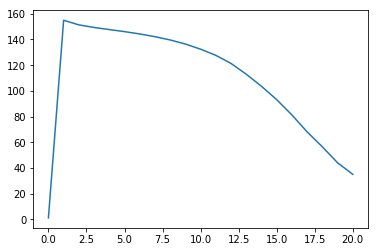

In [13]:
for epoch in range(NR_EPOCHS): 
    running_loss = 0.0
    running_corrects = 0.0
    start_time = time.time()
    print("Epoch:", epoch)
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
        inputs, labels = batch
        data_in = [s.to(device) for s in inputs['scenes']]
        labels = labels.to(device)
        
        #print(labels)
        
        optimizer.zero_grad() 
        
        outputs = test_net(data_in)
        #print('-----------------')

       
        _, preds = torch.max(outputs, 1)
        
       # print(outputs)
       
        
        #print(outputs.size(),'...',labels.size())
        loss = criterion(outputs[0:labels.size(0),:,SLICE_FROM_TIMESTEP:TIMESTEPS].float(),labels[:,SLICE_FROM_TIMESTEP:TIMESTEPS].long())
        loss.backward() 
        optimizer.step()
        
        running_loss += loss.data.item()*(data_in[0].size(0))
        running_corrects += torch.sum(preds[:,SLICE_FROM_TIMESTEP:TIMESTEPS].long() == labels[:,SLICE_FROM_TIMESTEP:TIMESTEPS].long())
        #print(running_corrects)
        #print(preds[:,SLICE_FROM_TIMESTEP:TIMESTEPS].long())
        #print(labels[:,SLICE_FROM_TIMESTEP:TIMESTEPS].long())
        
    epoch_loss = running_loss / len(dataset)
    epoch_acc = running_corrects.double() / (len(dataset)*(TIMESTEPS - SLICE_FROM_TIMESTEP))
    print("Loss epoch {}: {}, took {}s".format(epoch, epoch_loss,time.time()-start_time))
    print("Accuracy epoch {}: {}".format(epoch, epoch_acc))
    loss_array.append(running_loss)
    learning_rate_array.append(learning_rate)

#test_all_preds(test_net) 
print('...Training finished')
plt.plot(loss_array)

In [14]:
#DYNAMIC CHANGES:
NR_EPOCHS = 50
learning_rate = 0.01
momentum = 0.9
optimizer = optim.SGD(test_net.parameters(), lr=learning_rate, momentum=momentum)
print("LR changed")

LR changed


Expected loss:153.80572041353537, last loss:35.051902279257774
Batch size: 2
Sequence length: 15
Total epochs learnt: 21
Start testing...


KeyError: 'flows'

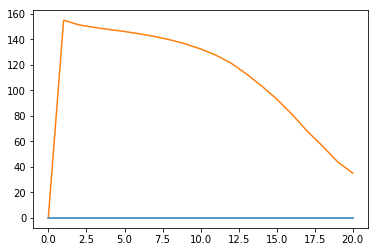

In [15]:
#EVALUATION
print("Expected loss:{}, last loss:{}".format((len(dataset)-split)*np.log(3),loss_array[-1]))
print("Batch size:", BATCH_SIZE)
print("Sequence length:",TIMESTEPS)
print("Total epochs learnt:", len(loss_array))
plt.plot(learning_rate_array)
plt.plot(loss_array)
test_all_preds(test_net)


In [ ]:
parameters_fc1 = list(test_net.fc1.parameters())
bias_fc1 = np.sort(parameters_fc1[1].detach().numpy())
weights_fc1 = np.sort(parameters_fc1[0].detach().numpy().flatten())


a = list(test_net.lstm2.parameters())
weights_lstm2 = np.array([])
for item in a:
    item = item.detach().numpy().flatten()
    #print(item)
    weights_lstm2 = np.concatenate((weights_lstm2,item))


parameters_conv5 = list(test_net.conv5.parameters())
bias_conv5 = np.sort(parameters_conv5[1].detach().numpy())
weights_conv5 = np.sort(parameters_conv5[0].detach().numpy().flatten())
#plt.figure()
#plt.plot(range(len(weights_conv1)),weights_conv1_init,range(len(weights_conv1)),weights_conv1)
#plt.figure()
#plt.plot(range(len(bias_conv1)),bias_conv1_init,range(len(bias_conv1)),bias_conv1)

##FC layers
plt.figure()
plt.plot(range(len(weights_conv5)),weights_conv5_init-weights_conv5)#,range(len(weights_conv5)),weights_conv5)
plt.figure()
plt.plot(range(len(bias_conv5)),bias_conv5_init-bias_conv5)#,range(len(bias_conv5)),bias_conv5)
#plt.figure()
#plt.plot(range(len(weight_lstm1_0)),weight_lstm1_0_init,range(len(weight_lstm1_0)),weight_lstm1_0)


plt.figure()
plt.plot(weights_lstm2_init-weights_lstm2)
## single plots
#plt.figure()
#plt.plot(range(len(weights_conv1)),weights_conv1_init)
#plt.figure()
#plt.plot(range(len(weights_conv1)),weights_conv1)

### Expected loss for untrained set with Cross Entropy:
k = number of classes
N = number of labeled data in dataset
loss_per_prediction = -log(1/k) = log(k)
total_loss = sum(log(k)) = N*log(k)

In [ ]:
plt.clf()
plot_path = "/home/matthias/Desktop/"
loss_str = "{0:.3f}".format(loss_array[-1])
information = "flows_L" + loss_str + "_timesteps{}_nrsequences{}_batch{}".format(TIMESTEPS,dataset_size,BATCH_SIZE)
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross Entropy)')
plt.plot(loss_array)
plt.title(information)
plt.savefig(plot_path + information + ".eps")
plt.clf()
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
plt.plot(learning_rate_array)
plt.title(information)
plt.savefig(plot_path + information + "LR.eps")

In [ ]:
print(outputs.size())
print(outputs[:,:,5:10])
print(outputs.size()[2])
print("Loss half:", criterion(outputs[:,:,SLICE_FROM_TIMESTEP:TIMESTEPS].float(),labels[:,SLICE_FROM_TIMESTEP:TIMESTEPS].long()))
print("Loss full:", criterion(outputs.float(),labels.long()))


In [ ]:
#for param in model.parameters():
#    print(type(param.data), param.size())
#parameters_fc1 = list(test_net.fc1.parameters())
#bias = np.sort(parameters_fc1[1].detach().numpy())
#weights = np.sort(parameters_fc1[0].detach().numpy().flatten())
parameters_conv5 = list(test_net.conv5.parameters())
bias_conv5 = np.sort(parameters_conv5[1].detach().numpy())
weights_conv5 = np.sort(parameters_conv5[0].detach().numpy().flatten())

In [ ]:
model = original_vgg.features
model.eval()


In [ ]:
#print(type(dataset[1]))
input_test = a["flows"][0]
input_test = torch.unsqueeze(input_test,0)
output = model(input_test)

In [ ]:
print(input_test.size())
print(output.size())

In [ ]:
parameters_lstm1 = list(test_net.lstm1.parameters())
print(len(parameters_lstm1[0]))

In [ ]:
image_list_ch_0 = []
image_list_ch_1 = []
image_list_ch_2 = []
for a,data in enumerate(dataset):
    print(a)
    for image in data[0]['scenes']:        
        image_list_ch_0.append(image[0].numpy())
        image_list_ch_1.append(image[1].numpy())
        image_list_ch_2.append(image[2].numpy())
print("List of channels created")
mean = [np.mean(image_list_ch_0),np.mean(image_list_ch_1),np.mean(image_list_ch_2)]
std_dev = np.sqrt([np.var(image_list_ch_0),np.var(image_list_ch_1),np.var(image_list_ch_2)])

In [ ]:
print(mean)
print(std_dev)